In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from collections import Counter
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [11]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
print(device)

mps


In [12]:
# 1. Parameters
BATCH_SIZE = 64
EMBED_DIM = 128
HIDDEN_DIM = 128
EPOCHS = 20
MAX_VOCAB_SIZE = 25_000
MAX_SEQ_LEN = 256
DEVICE = device

RANDOM_SEED = 27
torch.manual_seed(RANDOM_SEED)

In [13]:
device

'mps'

In [14]:
# Local base directory (relative to this notebook)

DATA_DIR = '../../ML_Tinkering_Python/data/aclImdb'

def load_imdb_data(data_dir, split):
    """Loads IMDB reviews from disk. Returns list of (label, text) tuples."""
    data = []
    for label in ('pos', 'neg'):
        labeled_dir = os.path.join(data_dir, split, label)
        for fname in os.listdir(labeled_dir):
            if fname.endswith('.txt'):
                with open(os.path.join(labeled_dir, fname), encoding='utf-8') as f:
                    text = f.read()
                    data.append((label, text))
    return data

In [15]:
# Assign train_data and test_data using the above function

train_data = load_imdb_data(DATA_DIR, 'train')
test_data = load_imdb_data(DATA_DIR, 'test')

In [16]:
# 3. Build Vocabulary
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_list):
    for label, text in data_list:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train_data)
    , specials=["<unk>", "<pad>"]
    , max_tokens=MAX_VOCAB_SIZE
)
vocab.set_default_index(vocab["<unk>"])

In [17]:
# 4. Text + Label Preprocessing
label_map = {"neg": 0, "pos": 1}

def process_text(text):
    tokens = tokenizer(text)
    token_ids = vocab(tokens)
    if len(token_ids) > MAX_SEQ_LEN:
        token_ids = token_ids[:MAX_SEQ_LEN]
    else:
        token_ids += [vocab["<pad>"]] * (MAX_SEQ_LEN - len(token_ids))
    return torch.tensor(token_ids, dtype=torch.long)

def process_label(label):
    return torch.tensor(label_map[label], dtype=torch.long)

In [18]:
# 5. Create PyTorch Dataset

class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = []
        for label, text in samples:
            self.samples.append((process_text(text), process_label(label)))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

train_dataset = IMDBDataset(train_data)
test_dataset = IMDBDataset(test_data)

In [19]:
# 6. Handle Imbalanced Dataset (Weighted Loss)

labels = [label.item() for _, label in train_dataset]

class_counts = Counter(labels)

class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]

sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(
    sample_weights
    , num_samples=len(sample_weights)
    , replacement=True
)

In [37]:
# NUM_WORKERS = os.cpu_count() / 2
# NUM_WORKERS

NUM_WORKERS = 0

NUM_WORKERS
# os.cpu_count()

0

In [36]:
os.cpu_count()

16

In [38]:
# 7. Create DataLoaders

train_loader = DataLoader(
    train_dataset
    , batch_size=BATCH_SIZE
    , sampler=sampler
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

test_loader = DataLoader(
    test_dataset
    , batch_size=BATCH_SIZE
    , shuffle=False
    , num_workers=0  # <-- Fix: Use single process (avoid pickle issues)
)

In [39]:
# 8. Define Model
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size
            , embed_dim
            , padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embed_dim
            , hidden_dim
            , batch_first=True
        )
        self.fc = nn.Linear(
            hidden_dim
            , num_classes
        )
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # hidden: (1, batch, hidden_dim)
        out = self.fc(hidden[-1])
        return out

In [40]:
#  Instantiate the model

model = SimpleLSTM(
    vocab_size=len(vocab)
    , embed_dim=EMBED_DIM
    , hidden_dim=HIDDEN_DIM
    , num_classes=2
    , pad_idx=vocab["<pad>"]
).to(DEVICE)

model

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [41]:
# 9. Loss and Optimizer
# Use weighted cross entropy to deal with class imbalance

# weights
weights = torch.tensor(
    class_weights
    , dtype=torch.float
).to(DEVICE)

# criterion (CEL)
criterion = nn.CrossEntropyLoss(
    weight=weights)


optimizer = optim.Adam(
    model.parameters(), lr=1e-3
    , weight_decay=1e-5 # added weight_decay to counteract overfitting (seen by decreasing test acc'y)
)

In [42]:
EPOCHS

20

In [46]:
# 10. Training Loop

for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
        preds = output.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)
    acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={acc:.4f}")

  0%|                                                    | 0/20 [00:00<?, ?it/s]

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

  5%|██▏                                         | 1/20 [00:22<07:00, 22.11s/it]

Epoch 1: Loss=0.6891, Acc=0.5277


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 10%|████▍                                       | 2/20 [00:44<06:36, 22.05s/it]

Epoch 2: Loss=0.6848, Acc=0.5326


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 15%|██████▌                                     | 3/20 [01:05<06:11, 21.87s/it]

Epoch 3: Loss=0.6669, Acc=0.5565


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 20%|████████▊                                   | 4/20 [01:27<05:48, 21.80s/it]

Epoch 4: Loss=0.6586, Acc=0.5794


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 25%|███████████                                 | 5/20 [01:49<05:27, 21.85s/it]

Epoch 5: Loss=0.6231, Acc=0.6005


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 30%|█████████████▏                              | 6/20 [02:10<05:03, 21.69s/it]

Epoch 6: Loss=0.5945, Acc=0.6177


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 35%|███████████████▍                            | 7/20 [02:32<04:41, 21.66s/it]

Epoch 7: Loss=0.6206, Acc=0.6248


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 40%|█████████████████▌                          | 8/20 [02:54<04:20, 21.72s/it]

Epoch 8: Loss=0.5961, Acc=0.6145


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 45%|███████████████████▊                        | 9/20 [03:15<03:58, 21.72s/it]

Epoch 9: Loss=0.5430, Acc=0.6968


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 50%|█████████████████████▌                     | 10/20 [03:38<03:38, 21.83s/it]

Epoch 10: Loss=0.5538, Acc=0.6381


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 55%|███████████████████████▋                   | 11/20 [03:59<03:16, 21.86s/it]

Epoch 11: Loss=0.5142, Acc=0.7000


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 60%|█████████████████████████▊                 | 12/20 [04:21<02:55, 21.91s/it]

Epoch 12: Loss=0.4832, Acc=0.7558


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 65%|███████████████████████████▉               | 13/20 [04:44<02:33, 21.97s/it]

Epoch 13: Loss=0.4690, Acc=0.7653


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 70%|██████████████████████████████             | 14/20 [05:06<02:12, 22.03s/it]

Epoch 14: Loss=0.3856, Acc=0.8293


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 75%|████████████████████████████████▎          | 15/20 [05:28<01:50, 22.05s/it]

Epoch 15: Loss=0.3622, Acc=0.8511


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 80%|██████████████████████████████████▍        | 16/20 [05:50<01:28, 22.02s/it]

Epoch 16: Loss=0.4362, Acc=0.7954


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 85%|████████████████████████████████████▌      | 17/20 [06:12<01:06, 22.04s/it]

Epoch 17: Loss=0.5061, Acc=0.6979


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 90%|██████████████████████████████████████▋    | 18/20 [06:34<00:44, 22.01s/it]

Epoch 18: Loss=0.3893, Acc=0.8236


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

 95%|████████████████████████████████████████▊  | 19/20 [06:56<00:22, 22.02s/it]

Epoch 19: Loss=0.2134, Acc=0.9231


SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

100%|███████████████████████████████████████████| 20/20 [07:18<00:00, 21.92s/it]

Epoch 20: Loss=0.1412, Acc=0.9544


In [47]:
# 11. Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        output = model(batch_x)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["neg", "pos"]))

SimpleLSTM(
  (embedding): Embedding(25000, 128, padding_idx=1)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

              precision    recall  f1-score   support

         neg       0.79      0.88      0.83     12500
         pos       0.86      0.77      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



In [48]:
# Initial confusion matrix:
confusion_matrix(all_labels, all_preds)

array([[10963,  1537],
       [ 2853,  9647]])

In [49]:
confusion_matrix(all_labels, all_preds)

array([[10963,  1537],
       [ 2853,  9647]])

In [50]:
(confusion_matrix(all_labels, all_preds)[0,0]/(confusion_matrix(all_labels, all_preds)[0,0]+confusion_matrix(all_labels, all_preds)[0,1])), (confusion_matrix(all_labels, all_preds)[0,1]/(confusion_matrix(all_labels, all_preds)[0,0]+confusion_matrix(all_labels, all_preds)[0,1]))

# print('\n')

(confusion_matrix(all_labels, all_preds)[1,0]/(confusion_matrix(all_labels, all_preds)[1,0]+confusion_matrix(all_labels, all_preds)[1,1])), (confusion_matrix(all_labels, all_preds)[1,1]/(confusion_matrix(all_labels, all_preds)[1,0]+confusion_matrix(all_labels, all_preds)[1,1]))

(0.87704, 0.12296)

(0.22824, 0.77176)

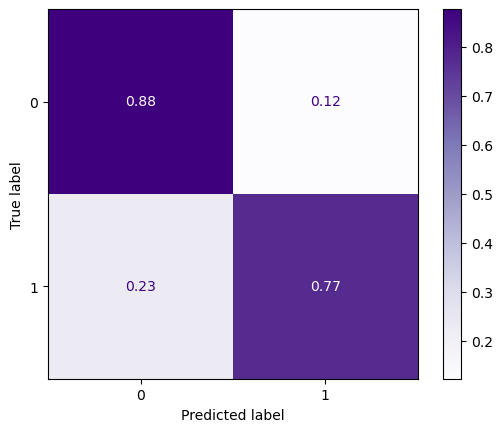

In [51]:
# Initial 
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize='true', cmap='Purples'
);

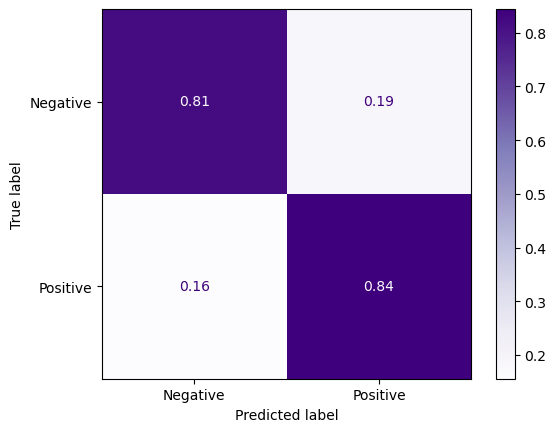

In [72]:
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize='true', cmap='Purples'
    , display_labels=["Negative", "Positive"]
);

In [52]:
# Function to retrain the model

# Trying a lower learning rate (lr) for retraining to counteract overfitting/ decreasing test acc'y; 
optimizer_r = optim.Adam(model.parameters(), lr=1e-4)

def retrain_model(model, train_loader, criterion, optimizer_r, device, epochs=10):
    """Retrains the model for a specified number of epochs."""
    print("Starting retraining...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)
            preds = output.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_x.size(0)
        acc = correct / total
        print(f"Epoch {epoch + 1}: Loss={total_loss / total:.4f}, Acc={acc:.4f}")
    print("Retraining complete.")

In [53]:
# Function to reevaluate the model
def reevaluate_model(model, test_loader, device):
    """Evaluates the model on the test set and prints metrics."""
    print("Starting reevaluation...")
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Print evaluation metrics
    print(classification_report(all_labels, all_preds, target_names=["neg", "pos"]))
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    ConfusionMatrixDisplay.from_predictions(
        all_labels, all_preds, normalize='true', cmap='Purples'
    )
    print("Reevaluation complete.")

In [54]:
# Example usage:
# Retrain for additional epochs
tqdm(retrain_model(model, train_loader, criterion, optimizer, DEVICE, epochs=20))

Starting retraining...
Epoch 1: Loss=0.1151, Acc=0.9647
Epoch 2: Loss=0.0855, Acc=0.9769
Epoch 3: Loss=0.0698, Acc=0.9815
Epoch 4: Loss=0.0535, Acc=0.9870
Epoch 5: Loss=0.0508, Acc=0.9875
Epoch 6: Loss=0.0429, Acc=0.9888
Epoch 7: Loss=0.0418, Acc=0.9899
Epoch 8: Loss=0.0345, Acc=0.9912
Epoch 9: Loss=0.0341, Acc=0.9914
Epoch 10: Loss=0.0288, Acc=0.9930
Epoch 11: Loss=0.0279, Acc=0.9926
Epoch 12: Loss=0.0257, Acc=0.9932
Epoch 13: Loss=0.0233, Acc=0.9945
Epoch 14: Loss=0.0239, Acc=0.9942
Epoch 15: Loss=0.0208, Acc=0.9951
Epoch 16: Loss=0.0180, Acc=0.9952
Epoch 17: Loss=0.0214, Acc=0.9943
Epoch 18: Loss=0.0191, Acc=0.9950
Epoch 19: Loss=0.0163, Acc=0.9960
Epoch 20: Loss=0.0179, Acc=0.9953
Retraining complete.


0it [00:00, ?it/s]

Starting reevaluation...
              precision    recall  f1-score   support

         neg       0.80      0.87      0.84     12500
         pos       0.86      0.79      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Confusion Matrix:
[[10906  1594]
 [ 2649  9851]]
Reevaluation complete.


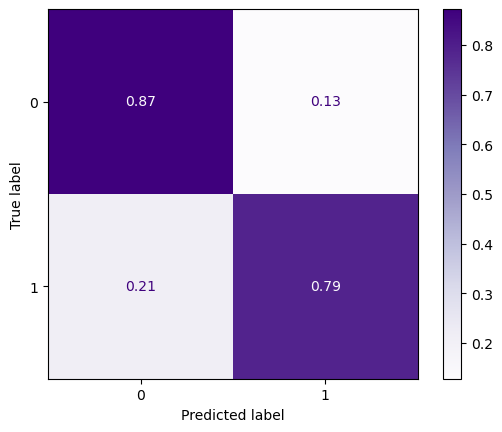

In [71]:
# Reevaluate the model on the test set
reevaluate_model(model, test_loader, DEVICE)

In [ ]:
# reevaluate_model(model, test_loader, DEVICE)
'''
init cm:
array([[10181,  2319],
       [ 1950, 10550]])

cm after retrain and reeval:
[[10906  1594]
 [ 2649  9851]]

'''

In [ ]:
"""Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """

In [58]:
# 7. Create DataLoaders
train_loader = train_dataloader(
    train_dataset
    , batch_size=BATCH_SIZE
    , sampler=sampler
    , num_workers=num_workers  # <-- Fix: Use single process (avoid pickle issues)
)

test_loader = test_dataloader(
    test_dataset
    , batch_size=BATCH_SIZE
    , shuffle=False
    , num_workers=num_workers  # <-- Fix: Use single process (avoid pickle issues)
)